In [1]:
# do imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import pandas as pd
import seaborn as sns

In [9]:
#extract shoot and root data from csv files
reads = np.empty((22383, 166))
OTUs = np.empty(22383, dtype=str)
plate = np.empty(166, dtype=str)
OTU = []
f = open('figure2A_raw.csv', 'r')
i = 0
# Parsing the data
for line in f:
    line = line.strip()
    line = line.split(',')
    if line[0] == '""':
        for j in range(len(line)):
            line[j] = line[j][1:-1]
        plate = line[1::] # Save plates
    else:
        reads[i] = line[1::]
        if line[0][1] == 'A':
            line[0] = line[0][1:-1]
            OTU.append(line[0]) # Save ASVs
        i += 1
OTUs = OTU

# Initialize index lists
root_ind = []
shoot_ind = []
soil_ind = []
q = open('data_Fig2A_S2A.csv', 'r') # This has the metadata, ie part of the plant
for row in q:
    row = row.strip()
    row = row.split(',')
    pos = row[0]+'_'+row[1]
    #if row[6] == 'Col-0': # From Figure 2A analysis
    # Saving indices for sites
    if row[8] == 'Root':
        root_ind.append(plate.index(pos))
    if row[8] == 'Soil':
        soil_ind.append(plate.index(pos))
    if row[8] == 'Shoot':
        shoot_ind.append(plate.index(pos))

    """ 
    Stuff from figure 2a:
    
    if row[6] == 'phf1':
        if row[8] == 'Root':
            root_ind[1].append(plate.index(pos))
        if row[8] == 'Soil':
            soil_ind[1].append(plate.index(pos))
        if row[8] == 'Shoot':
            shoot_ind[1].append(plate.index(pos))
    if row[6] == 'phr1/phl1':
        if row[8] == 'Root':
            root_ind[2].append(plate.index(pos))
        if row[8] == 'Soil':
            soil_ind[2].append(plate.index(pos))
        if row[8] == 'Shoot':
            shoot_ind[2].append(plate.index(pos))
root_col = np.array(root_ind[0])
root_phf = np.array(root_ind[1])
root_phr = np.array(root_ind[2])
soil_col = np.array(soil_ind[0])
soil_phf = np.array(soil_ind[1])
soil_phr = np.array(soil_ind[2])
shoot_col = np.array(shoot_ind[0])
shoot_phf = np.array(shoot_ind[1])
shoot_phr = np.array(shoot_ind[2])
"""

In [3]:
plate_2 = []
q = open('data_Fig2A_S2a.csv', 'r')
for row in q:
    row = row.strip()
    row = row.split(',')
    plate_2.append(row[0] +'_'+ row[1])
plate_2 = plate_2[1::]

extras = []
for i in plate:
    if i not in plate_2:
        extras.append(plate.index(i))

In [5]:
print(len(plate_2))

159


In [10]:
reads = np.delete(reads, extras, axis=1)
print(reads.shape)

(22383, 159)


In [11]:
#rarefy the data
# Do imports
from numpy.random import RandomState 

def rarefaction(M, seed=0):
    '''Rarefies an array M. Allows seed to be set for reproducible results.'''
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=0) # number of occurrences for each sample
    nvar = M.shape[0] # number of variables
    depth = 3000

    Mrarefied = np.empty_like(M)
    for i in range(M.shape[1]): # for each sample
        p = M[:,i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[:,i] = np.bincount(choice, minlength=nvar)

    return Mrarefied

In [12]:
# Rarefy data
rare = rarefaction(reads, seed=130816)
print(rare.shape)

(22383, 159)


In [13]:
# We got the rarefaction to work so we don't need this code...
#rare = np.delete(rare, extras, axis=1)
#print(rare.shape)

In [14]:
# Calculate bray-curtis dissimilarities
from scipy.spatial import distance

result = np.zeros((rare.shape[1], rare.shape[1]))

for i in range(rare.shape[1]):
    for j in range(rare.shape[1]):
        result[i,j] = distance.braycurtis(rare[:,i], rare[:,j])
    
#soil = np.concatenate((rare[:, soil_col], rare[:, soil_phf], rare[:, soil_phr]), axis=1)
#root = np.concatenate((rare[:, root_col], rare[:, root_phf], rare[:, root_phr]), axis=1)
#soil_flip = np.transpose(soil)
#root_flip = np.transpose(root)
#for column in range(len(soil_flip)):
    #print(distance.braycurtis(soil_flip[column], root_flip[column]))

In [15]:
print(result[0])
# Yay! Bray-Curtis dissimilarities look good

[0.         0.906      0.984      0.773      0.97733333 0.93066667
 0.94166667 0.967      0.75566667 0.73533333 0.558      0.86966667
 0.70966667 0.92933333 0.86533333 0.85066667 0.85533333 0.73733333
 0.95433333 0.74133333 0.853      0.65166667 0.93233333 0.64033333
 0.873      0.675      0.94933333 0.95966667 0.98366667 0.87466667
 0.72933333 0.93733333 0.82966667 0.93233333 0.96833333 0.96966667
 0.92066667 0.938      0.785      0.84033333 0.94633333 0.86433333
 0.93233333 0.93633333 0.89366667 0.66533333 0.93733333 0.94933333
 0.88333333 0.968      0.625      0.869      0.97233333 0.85633333
 0.88133333 0.763      0.977      0.82466667 0.932      0.867
 0.947      0.944      0.73566667 0.93566667 0.964      0.71633333
 0.794      0.90733333 0.972      0.73166667 0.93966667 0.933
 0.89766667 0.92566667 0.927      0.969      0.974      0.71666667
 0.98066667 0.60533333 0.983      0.68866667 0.934      0.886
 0.71766667 0.96866667 0.67466667 0.89666667 0.959      0.97333333
 0.892    

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(rare)
print('Variance Explained: ', pca.explained_variance_ratio_)

Variance Explained:  [0.24148596 0.15631404]


ValueError: 'c' argument has 159 elements, which is not acceptable for use with 'x' with size 22383, 'y' with size 22383.

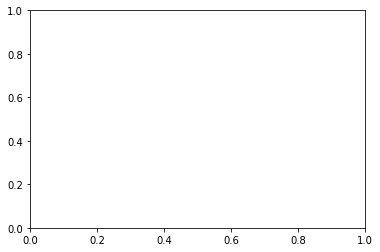

In [28]:
rare_pca = pca.fit(rare)
rare_pca = pca.transform(rare)
plt.scatter(rare_pca[:,0], rare_pca[:,1], c = target, s =0.4, cmap=plt.cm.get_cmap('brg',4))
plt.colorbar();

In [49]:
# PCA imports
from sklearn.decomposition import PCA
# finding principle components
pca = PCA(n_components = 3) # this defines the model
pca.fit(result) # this fits the model
# a good measure of performance
#print('Variance Explained: ', pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:

# Make target variable to label sites as 0, 1 and 2
#target = np.zeros(result.shape[1])
#for i in range(site_ind.size-1):
    #target[site_ind[i]:site_ind[i+1]] = i
target = np.zeros((159))
for i in range(target.size):
    if i in root_ind:
        target[i] = 0
    if i in soil_ind:
        target[i] = 1
    if i in shoot_ind:
        target[i] = 2
print(len(target))

159


In [59]:
# PCA imports
from sklearn.decomposition import PCA
# finding principle components
pca = PCA(n_components = 5) # this defines the model
pca.fit(result) # this fits the model
# a good measure of performance
print('Variance Explained: ', pca.explained_variance_ratio_)

Variance Explained:  [0.32931303 0.16882116 0.13735137 0.0659648  0.03862332]


In [57]:
# PCA vizualization
result_pca = pca.transform(result) # transform the data into PCA space
##plt.colorbar();
# Color labels different sites.
# There is reasonable separation between different sites.


array([ 0.20009667,  0.25157604,  0.93071928,  0.38736319,  0.93637728,
        0.13765604,  1.03733774,  0.75874546, -0.03826468, -0.23449471,
        0.14497124,  0.8682437 , -0.07152324, -1.09997645,  1.01149568,
       -0.46222051,  0.95597348, -0.1591676 ,  0.19952211,  0.84491172,
       -0.0686385 , -0.1777664 ,  0.68772957, -0.02900906,  0.93255529,
       -0.06383685,  0.13255694, -0.15757514, -0.2723129 ,  0.99679732,
        0.77110626,  1.01267722, -0.02859803, -0.86523342,  0.79058416,
        0.1822489 , -0.4049709 , -0.63582547,  0.03033463,  0.00833011,
       -1.15807582, -0.10207045, -0.05994381, -1.00789845,  0.1917923 ,
       -0.1662266 , -0.27403306, -0.97621428,  1.37178832, -0.43207488,
        0.05758962,  0.94081743,  0.0582808 ,  0.11017597, -0.72186313,
        0.2096067 ,  0.22370403,  0.03578906, -0.95962525,  1.11660783,
       -0.81842213,  0.75444504, -0.04244701, -0.89518247,  0.00482735,
        0.06307945, -0.16745025, -0.8905047 , -0.34704244,  0.05

In [54]:
from sklearn.manifold import MDS
# finding principle components
mds = MDS(n_components=5)
mds.fit(result)
print('Variance Explained: ', mds.explained_variance_ratio_)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=5, n_init=4, n_jobs=None, random_state=None, verbose=0)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


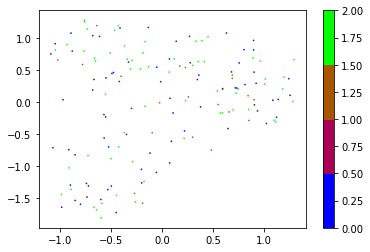

In [55]:
# MDS vizualization
X_mds = mds.fit_transform(result)
plt.scatter(X_mds[:,0], X_mds[:,1], c = target, s =0.4, cmap=plt.cm.get_cmap('brg',4))
plt.colorbar();
# this looks different, but it is not clear that the separation is better than in regular PCA

In [62]:
# Next, we try t-stochastic neighbor embedding t-SNE
# t-SNE imports
from sklearn.manifold import TSNE
# finding principle components
tsne = TSNE(n_components=2)
tsne.fit(result)
#print('Variance Explained: ', tsne.explained_variance_ratio_)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

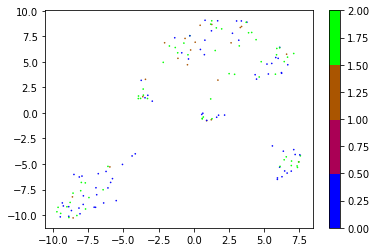

In [63]:
# t-SNE vizualization
X_tsne = tsne.fit_transform(result)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = target, s =0.4, cmap=plt.cm.get_cmap('brg',4))
plt.colorbar();
# This is much better than PCA because the clusters are very distinct.
# The non-linear transformation is evident in the shapes and the fact
# that the brown cluster is detached from red and green clusters.

In [73]:
from sklearn.cross_decomposition import CCA
annoyed = CCA(n_components = 2)
#annoyed.fit(result, result)
x_cca = annoyed.fit_transform(result, y=None)
plt.scatter(x_cca[:,0], x_cca[:,1], c = target, s =0.4, cmap=plt.cm.get_cmap('brg',4))
plt.colorbar();

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').